# インテグレーションステップ プロジェクト

In [32]:
%matplotlib inline
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import scipy as sp
from scipy import stats
from scipy.stats import spearmanr

import psycopg2
from pandas import DataFrame
from __future__ import print_function

#xgboostをインポート
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold

#Scikit-learnをインポート
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#不均衡サンプリング
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [2]:
db_params = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'takashdb',
    'host': 'localhost',
    'port': 5432
}

con = psycopg2.connect(**db_params)

# データ抽出

先発投手

In [3]:
sp_sql = """
select *
  from baseball.v_sum_for_cluster_sp
"""

In [4]:
cluster_sp_sql = psql.read_sql(con=con, sql=sp_sql)
cluster_sp_sql

,period,team_cd_dl,team_cd,team_name,player_cd,player_no,player_name,game,win,lose,...,hr_total,fourball_total,deadball_total,struckout_total,run_total,earned_run_total,era,whip_total,dips_total,kbb
0,2017,D,DB,横浜DeNAベイスターズ,DBn15,15,井納 翔一,25.0,6.0,10.0,...,9.0,46.0,8.0,93.0,66.0,65.0,3.85,1.27,3.71,1.72
1,2017,D,DB,横浜DeNAベイスターズ,DBn21,21,今永 昇太,24.0,11.0,7.0,...,13.0,52.0,5.0,140.0,49.0,49.0,2.98,1.13,3.48,2.46
2,2017,D,DB,横浜DeNAベイスターズ,DBn56,56,ウィーランド,21.0,10.0,2.0,...,14.0,37.0,2.0,112.0,46.0,44.0,2.98,1.14,3.68,2.87
3,2017,D,DB,横浜DeNAベイスターズ,DBn26,26,濵口 遥大,22.0,10.0,6.0,...,9.0,69.0,2.0,136.0,54.0,49.0,3.58,1.50,3.59,1.92
4,2017,D,DB,横浜DeNAベイスターズ,DBn14,14,石田 健大,18.0,6.0,6.0,...,10.0,34.0,0.0,103.0,43.0,40.0,3.40,1.17,3.37,3.03
5,2017,広,C,広島東洋カープ,Cnn19,19,野村 祐輔,25.0,9.0,5.0,...,12.0,38.0,4.0,106.0,53.0,48.0,2.79,1.22,3.57,2.52
6,2017,広,C,広島東洋カープ,Cnn14,14,大瀬良 大地,24.0,10.0,2.0,...,12.0,43.0,1.0,109.0,68.0,59.0,3.66,1.28,3.60,2.48
7,2017,広,C,広島東洋カープ,Cnn17,17,岡田 明丈,24.0,12.0,5.0,...,9.0,63.0,4.0,109.0,68.0,63.0,4.02,1.39,3.83,1.63
8,2017,広,C,広島東洋カープ,Cnn23,23,薮田 和樹,38.0,15.0,3.0,...,10.0,51.0,4.0,115.0,42.0,37.0,2.58,1.19,3.62,2.09
9,2017,広,C,広島東洋カープ,Cnn12,12,九里 亜蓮,35.0,9.0,5.0,...,7.0,44.0,4.0,97.0,51.0,47.0,3.64,1.33,3.47,2.02


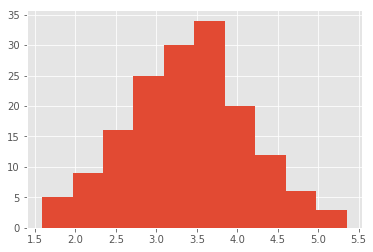

In [5]:
#データの分布（ヒストグラム）
cluster_sp_sql['era'].hist()

リリーフ投手

In [6]:
rp_sql = """
select *
  from baseball.v_sum_for_cluster_rp
"""

In [7]:
cluster_rp_sql = psql.read_sql(con=con, sql=rp_sql)
cluster_rp_sql

,period,team_cd_dl,team_cd,team_name,player_cd,player_no,player_name,games,win,lose,...,earned_run,pitch_per_inning,era,whip,kbb,ave_inning,ave_max_speed,std_max_speed,ave_speed_diff,std_speed_diff
0,2017,ヤ,YS,東京ヤクルトスワローズ,YSn12,12,石山 泰稚,66,3,6,...,23.0,17.34,3.03,1.14,5.43,1.04,148.26,2.29,23.73,4.69
1,2016,ロ,M,千葉ロッテマリーンズ,Mnn33,33,南 昌輝,57,5,4,...,19.0,16.84,2.74,1.07,3.22,1.09,146.51,1.63,29.28,10.35
2,2015,オ,BS,オリックスバファローズ,BSn59,59,塚原 頌平,41,0,4,...,16.0,16.88,3.30,1.51,1.04,1.06,148.63,1.36,21.93,7.18
3,2017,楽,E,東北楽天ゴールデンイーグルス,Enn53,53,高梨 雄平,46,1,0,...,5.0,18.76,1.03,1.12,3.00,0.95,140.04,2.90,16.37,3.41
4,2015,日,F,北海道日本ハムファイターズ,Fnn43,43,白村 明弘,50,1,1,...,13.0,16.95,2.03,1.11,3.47,1.15,151.00,1.82,21.40,6.55
5,2015,ロ,M,千葉ロッテマリーンズ,Mnn14,14,大谷 智久,56,3,1,...,17.0,16.16,2.39,1.00,10.60,1.14,145.04,1.95,28.27,3.47
6,2015,中,D,中日ドラゴンズ,Dnn12,12,田島 慎二,64,4,6,...,19.0,16.38,2.28,1.29,2.70,1.17,147.27,1.97,19.17,3.45
7,2015,中,D,中日ドラゴンズ,Dnn16,16,又吉 克樹,63,6,6,...,27.0,17.25,3.36,1.26,3.57,1.15,146.60,2.05,20.24,4.79
8,2015,日,F,北海道日本ハムファイターズ,Fnn25,25,宮西 尚生,50,3,3,...,12.0,15.43,2.70,1.00,3.00,0.80,141.02,3.52,13.36,4.61
9,2017,阪,T,阪神タイガース,Tnn41,41,髙橋 聡文,61,6,0,...,9.0,15.51,1.70,0.92,3.64,0.78,141.02,2.45,15.26,5.51


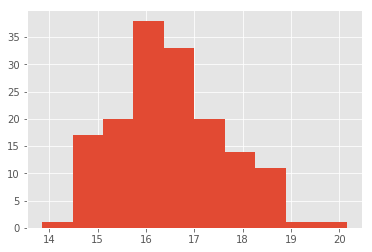

In [8]:
#データの分布（ヒストグラム）
cluster_rp_sql['pitch_per_inning'].hist()

In [9]:
def cluter_visualize(data, cluster_labels):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
    cluster_ids = list(set(cluster_labels))
    for k in range(len(cluster_ids)):
        cluster_id = cluster_ids[k]
        label_ = "clutser = %d"%cluster_id
        data_by_cluster = data[cluster_labels == cluster_id]
#        ax.scatter(data_by_cluster[:,0], data_by_cluster[:,1], c=colorlist[k], label = label_)
        ax.scatter(data_by_cluster[:,0], data_by_cluster[:,1], c=colorlist[k])

    ax.set_title(u"Clustering")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc='lower right')

In [44]:
#正規化（最小値0、最大値1）
scaler = MaxAbsScaler()

#平均0，標準偏差1に正規化する場合はStandardScalerを用いる。
#scaler = StandardScaler()

# K-meansでクラスタリング

先発投手

In [45]:
#クラスタリングデータ項目
#cluster_cols_sp = ['whip','kbb','ave_inning','ave_max_speed','ave_speed_diff','era']
cluster_cols_sp = ['era','whip_total','kbb','inning_total']
cluster_sp_data = cluster_sp_sql[cluster_cols_sp]

cluster_sp_data = scaler.fit_transform(cluster_sp_data)
cluster_sp_array = np.array(cluster_sp_data)

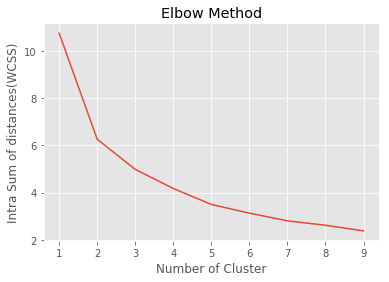

In [46]:
#Elbow methodで最適なクラスター数を導出
max_cluster = 10
clusters_ = range(1, max_cluster)

#K-Meansによる距離の総和を配列に
intra_sum_of_square_list = []
for k in clusters_:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
    km.fit(cluster_sp_array)
    intra_sum_of_square_list.append(km.inertia_)

#グラフの描画
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Cluster')
ax.set_ylabel('Intra Sum of distances(WCSS)')
plt.plot(clusters_, intra_sum_of_square_list)

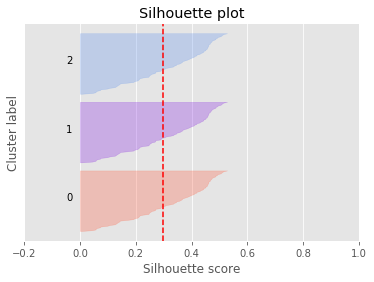

In [47]:
#シルエットプロット
#K-Meansクラスタリングの実行
n_clusters = 3
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300)
km.fit(cluster_sp_array)
cluster_labels = km.predict(cluster_sp_array)
colorlist = ['tomato','blueviolet','cornflowerblue','darkgreen','skyblue','mediumseagreen']

#シルエットスコアの平均を計算
silhouette_avg = silhouette_score(cluster_sp_array, cluster_labels)

#それぞれのデータ点のシルエットスコアを計算する
each_silhouette_score = silhouette_samples(cluster_sp_array, cluster_labels, metric='euclidean')

#描画
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = each_silhouette_score[cluster_labels == 1]
    ith_cluster_silhouette_values.sort()    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = colorlist[i]
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.3)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title('Silhouette plot')
ax.set_xlabel('Silhouette score')
ax.set_ylabel('Cluster label')
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [48]:
#クラスタリング用のデータ項目
pred = KMeans(n_clusters=3).fit_predict(cluster_sp_array)
cluster_sp_sql['cluster_id']=pred

In [49]:
cluster_sp_sql

,period,team_cd_dl,team_cd,team_name,player_cd,player_no,player_name,game,win,lose,...,fourball_total,deadball_total,struckout_total,run_total,earned_run_total,era,whip_total,dips_total,kbb,cluster_id
0,2017,D,DB,横浜DeNAベイスターズ,DBn15,15,井納 翔一,25.0,6.0,10.0,...,46.0,8.0,93.0,66.0,65.0,3.85,1.27,3.71,1.72,0
1,2017,D,DB,横浜DeNAベイスターズ,DBn21,21,今永 昇太,24.0,11.0,7.0,...,52.0,5.0,140.0,49.0,49.0,2.98,1.13,3.48,2.46,1
2,2017,D,DB,横浜DeNAベイスターズ,DBn56,56,ウィーランド,21.0,10.0,2.0,...,37.0,2.0,112.0,46.0,44.0,2.98,1.14,3.68,2.87,1
3,2017,D,DB,横浜DeNAベイスターズ,DBn26,26,濵口 遥大,22.0,10.0,6.0,...,69.0,2.0,136.0,54.0,49.0,3.58,1.50,3.59,1.92,0
4,2017,D,DB,横浜DeNAベイスターズ,DBn14,14,石田 健大,18.0,6.0,6.0,...,34.0,0.0,103.0,43.0,40.0,3.40,1.17,3.37,3.03,0
5,2017,広,C,広島東洋カープ,Cnn19,19,野村 祐輔,25.0,9.0,5.0,...,38.0,4.0,106.0,53.0,48.0,2.79,1.22,3.57,2.52,1
6,2017,広,C,広島東洋カープ,Cnn14,14,大瀬良 大地,24.0,10.0,2.0,...,43.0,1.0,109.0,68.0,59.0,3.66,1.28,3.60,2.48,0
7,2017,広,C,広島東洋カープ,Cnn17,17,岡田 明丈,24.0,12.0,5.0,...,63.0,4.0,109.0,68.0,63.0,4.02,1.39,3.83,1.63,0
8,2017,広,C,広島東洋カープ,Cnn23,23,薮田 和樹,38.0,15.0,3.0,...,51.0,4.0,115.0,42.0,37.0,2.58,1.19,3.62,2.09,1
9,2017,広,C,広島東洋カープ,Cnn12,12,九里 亜蓮,35.0,9.0,5.0,...,44.0,4.0,97.0,51.0,47.0,3.64,1.33,3.47,2.02,0


C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


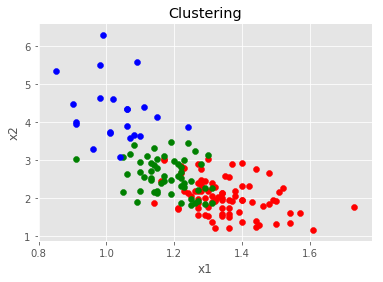

In [52]:
#cluster_sp = cluster_sp_sql[cluster_sp_sql['period'] =='2017']
cluster_sp = cluster_sp_sql

cluster_p = np.array(cluster_sp[['whip_total','kbb','inning_total']])
cluter_visualize(cluster_p, pred)

In [13]:
cluster_sp_sql.to_csv("cluster_sp.csv", index=False)

リリーフ投手

In [11]:
#クラスタリング用のデータ項目
#cluster_cols_rp = ['whip','kbb','ave_inning','ave_max_speed','ave_speed_diff','era']
cluster_cols_rp = ['era','kbb','whip','pitch_per_inning']
cluster_rp_data = cluster_rp_sql[cluster_cols_rp]
cluster_rp_array = np.array(cluster_rp_data)

pred = KMeans(n_clusters=4).fit_predict(cluster_rp_array)
cluster_rp_sql['cluster_id']=pred

In [12]:
cluster_rp_sql.to_csv("cluster_rp.csv", index=False)

In [13]:
rp_output = ['period','player_cd','cluster_id']
output = cluster_rp_sql[rp_output]
output.to_csv("rp_output.csv", index=False)